In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import linalg

In [2]:
train_data = np.genfromtxt('X_train.csv', delimiter=',')
train_label = np.genfromtxt('T_train.csv', delimiter=',')
test_data = np.genfromtxt('X_test.csv', delimiter=',')
test_label = np.genfromtxt('T_test.csv', delimiter=',')

In [3]:
train_data.shape, train_label.shape

((5000, 784), (5000,))

# PCA Principal Components Analysis

find a orthogonal projection $W$ has minimum MSE(mean square error)

$$ z = xW \\
MSE = ||x - zW^T||^2 = || x - xWW^T ||^2 \\
= \text{constant} - \text{constant}W^TSW, S_{i,j} = \frac{\sum_{k=1}^N (x_{k}(i) - \bar{x(i)})(x_{k}(j) - \bar{x(j)})^T}{N}, x = \left[ \begin{matrix} x(0) \\ x(1) \\ \vdots \\ x(d) \end{matrix} \right]$$

$W^TSW$ is covariance matrix, so we can maximize $W^TSW$ and get minimum MSE

It become a Rayleigh quotient problem, find eigen vector with max eigen value.

In [4]:
def covariance(x, y):
    x1 = x - np.sum(x, axis = 1)[:,None]
    y1 = y - np.sum(y, axis = 1)[:,None]
    return np.matmul(x1, y1.T)/ x1.shape[1]

In [5]:
# parameter
dim = 2
S = covariance(train_data.T, train_data.T)
S.shape

(784, 784)

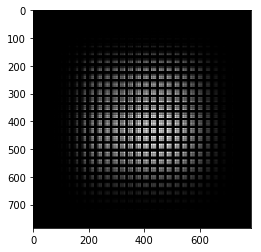

In [6]:
plt.imshow(S, cmap='gray')

In [15]:
%%time
eigen_values, eigen_vectors = linalg.eig(S)

CPU times: user 5.12 s, sys: 7.88 s, total: 13 s
Wall time: 1.81 s


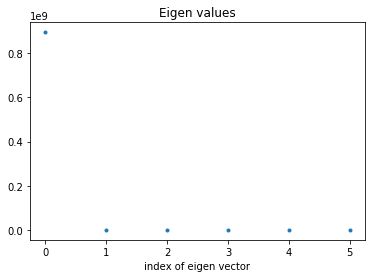

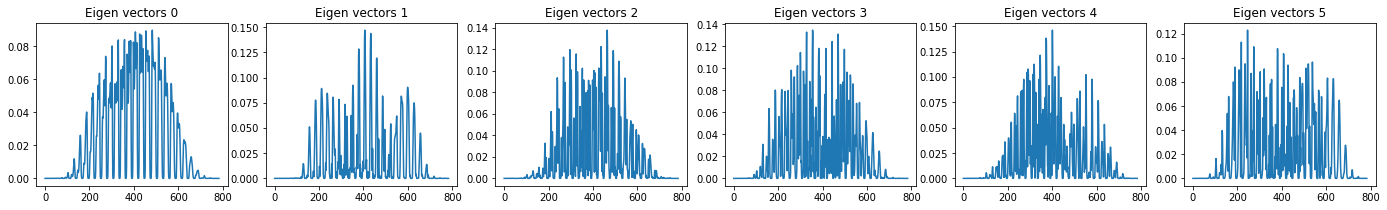

In [16]:
# show eigen vector with max eigen value

max_idxs = np.flip(np.argsort(np.abs(eigen_values)))

show_number = 6

plt.plot(np.abs(eigen_values[max_idxs[:show_number]]),'.')
plt.xticks(range(show_number), max_idxs[:show_number])
plt.title('Eigen values')
plt.xlabel('index of eigen vector')
plt.show()

plt.figure(figsize=(4*show_number,3))

for i in range(show_number):
    plt.subplot(1, show_number, i+1)
    plt.plot(np.abs(eigen_vectors[:,max_idxs[i]]))
    plt.title('Eigen vectors '+str(max_idxs[i]))

plt.show()

In [17]:
max_idxs = np.flip(np.argsort(np.abs(eigen_values)))
W = np.concatenate([np.abs(eigen_vectors[:, max_idxs[i]])[:,None] for i in range(dim)], axis=1)
W.shape    

(784, 2)

In [18]:
project = np.matmul(train_data, W)
project.shape

(5000, 2)

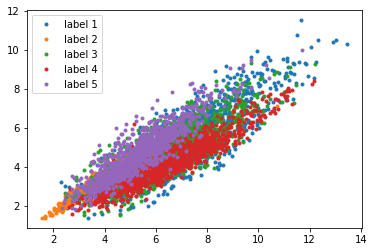

In [19]:
for t in range(1,6):
    mask = train_label == t
    plt.plot(project[mask,0], project[mask,1], '.', label='label '+str(t))
    
plt.legend()

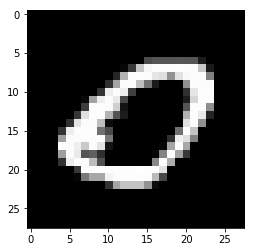

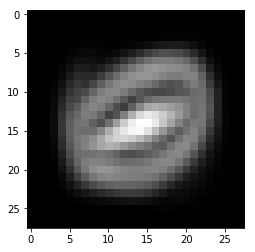

In [20]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')
plt.show()
plt.imshow(np.matmul(np.matmul(train_data[0],W), W.T).reshape(28,28), cmap='gray')

# LDA Linear Discriminative Analysis

- has $k$ classes
- maximize between-class-scatter $S_B = \sum_{j=1}^k |C_j|(m_j - m)(m_j - m)^T, m = \frac{\sum x}{n}, m_j = \frac{\sum_{x_i \in C_j} x_i}{|C_j|}$
- minimize within-class-scatter  $S_W = \sum_{j=1}^k \sum_{x_i \in C_j} (x_i - m_j)(x_i - m_j)^T$
- solve eigen problem $ S_B W = \lambda S_W W  \Rightarrow S_W^{-1} S_B W = \lambda W$

In [13]:
# parameter
dim = 2
C = np.zeros((train_data.shape[0], len(np.unique(train_label))))
for idx, j in enumerate(np.unique(train_label)):
    C[train_label == j,idx] = 1;

Mj = np.matmul(train_data.T, C) / np.sum(C, axis = 0)
M = np.sum(train_data.T, axis = 1) / train_data.shape[0]
B = Mj - M[:,None]    
SB = np.matmul(B * np.sum(C, axis = 0), B.T) 
W = train_data.T - np.matmul(Mj, C.T)
SW = np.matmul(W, W.T)

SB.shape, SW.shape

((784, 784), (784, 784))

In [50]:
SBW = np.matmul(np.linalg.pinv(SW), SB)
SBW.shape

(784, 784)

In [51]:
%%time
eigen_values, eigen_vectors = linalg.eig(SBW)

CPU times: user 6.45 s, sys: 10.1 s, total: 16.6 s
Wall time: 2.33 s


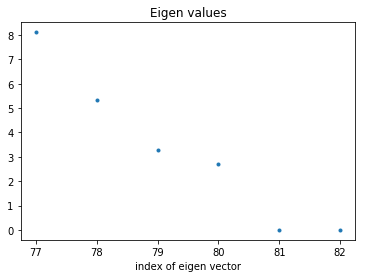

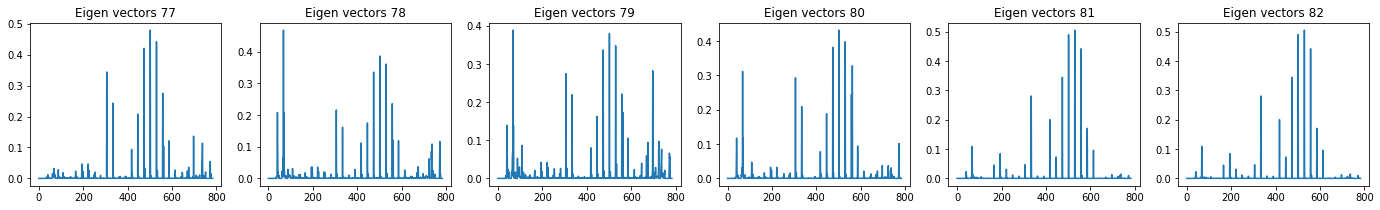

In [52]:
# show eigen vector with max eigen value

max_idxs = np.flip(np.argsort(np.abs(eigen_values)))

show_number = 6

plt.plot(np.abs(eigen_values[max_idxs[:show_number]]),'.')
plt.xticks(range(show_number), max_idxs[:show_number])
plt.title('Eigen values')
plt.xlabel('index of eigen vector')
plt.show()

plt.figure(figsize=(4*show_number,3))

for i in range(show_number):
    plt.subplot(1, show_number, i+1)
    plt.plot(np.abs(eigen_vectors[:,max_idxs[i]]))
    plt.title('Eigen vectors '+str(max_idxs[i]))

plt.show()

In [53]:
max_idxs = np.flip(np.argsort(np.abs(eigen_values)))
W = np.concatenate([np.abs(eigen_vectors[:, max_idxs[i]])[:,None] for i in range(dim)], axis=1)
W.shape 

(784, 2)

In [54]:
project = np.matmul(train_data, W)
project.shape

(5000, 2)

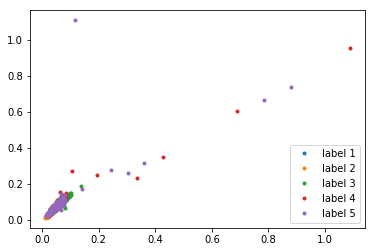

In [55]:
for t in range(1,6):
    mask = train_label == t
    plt.plot(project[mask,0], project[mask,1], '.', label='label '+str(t))
    
plt.legend()